### Code 11.64

In [1]:
import pandas as pd
import arviz as az
import pymc as pm
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
d = pd.read_csv("./Data/AustinCats.csv", delimiter=";")
d["adopt"] = 1
d.adopt = d.adopt.where(d.out_event == "Adoption", 0)
d["color_id"] = 0
d.color_id = d.color_id.where(d.color == "Black", 1)

d_obs = d[d.adopt == 1]
d_cens = d[d.adopt == 0]

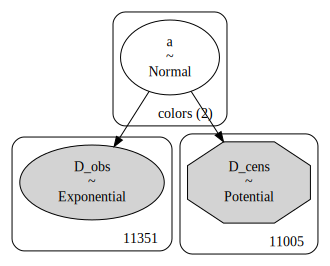

In [9]:
from pymc.math import exp

coords = {"colors": ["black", "non-black"]}
    
with pm.Model(coords=coords) as m11_14:
    a = pm.Normal("a", mu=0, sigma=1, dims="colors")
    
    mu_obs = exp(a[d_obs.color_id])
    likelihood_obs = pm.Exponential("D_obs", lam=1/mu_obs, observed=d_obs.days_to_event)
    
    mu_cens = exp(a[d_cens.color_id])
    exp_lccdf = -1/mu_cens * d_cens.days_to_event
    likelihood_cens = pm.Potential("D_cens", exp_lccdf)
    
pm.model_to_graphviz(m11_14)

In [4]:
with m11_14:
    trace11_14 = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [5]:
az.summary(trace11_14, var_names=["a"], round_to=2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a[black],4.05,0.03,4.00,4.1
a[non-black],3.88,0.01,3.86,3.9


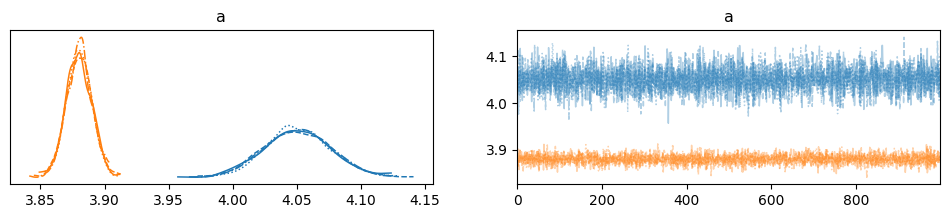

In [6]:
az.plot_trace(trace11_14);

In [7]:
trace11_14.posterior["D"] = np.exp(trace11_14.posterior.a)

In [8]:
az.summary(trace11_14, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
a[black],4.05,0.03,4.00,4.10
a[non-black],3.88,0.01,3.86,3.90
D[black],57.46,1.47,54.70,60.18
D[non-black],48.43,0.47,47.59,49.36


In [99]:
diff_a = post_a[0, :] - post_a[1, :]
az.summary({"diff_a": diff_a}, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.17,0.03,0.12,0.23
